In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

443


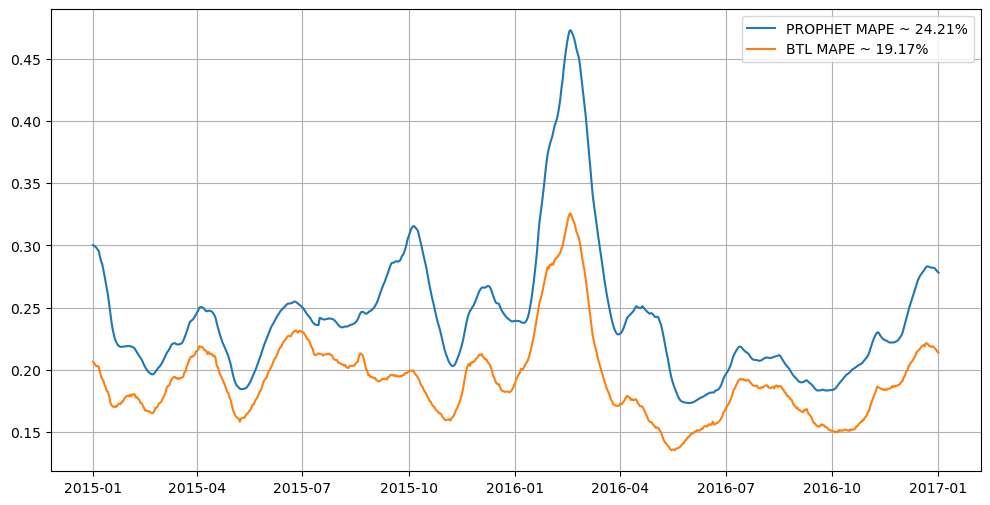

In [24]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
prophet_parent_path = Path("./") / "out" / "prophet"
vangja_parent_path = Path("./") / "out" / "vangja"

paths = [
    prophet_parent_path / "test2",
    vangja_parent_path / "test_ciit_0",
]
labels = [
    "PROPHET",
    "BTL",
]
index = None

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_lt0_w"
    csv_path = paths[0] / f"{model_name}.csv"
    vangja_path = paths[1] / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    index_1 = pd.read_csv(csv_path, index_col=0).index
    index_2 = pd.read_csv(vangja_path, index_col=0).index
    index_1 = index_1.intersection(index_2)
    if index is None:
        index = index_1

    index = index.intersection(index_1)

print(len(index))
plt.figure(figsize=(12, 6))

metrics_per_ticker = [{}, {}]
total_metrics = []

for idx, (path, label) in enumerate(zip(paths, labels)):
    dates = []
    mapes = []
    maes = []
    rmses = []
    mses = []
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
        csv_path = (
            path / f"prophet_{point_str}_multiplicative_lt0_w.csv"
            if idx == 0
            else path / f"{point_str}.csv"
        )

        if not csv_path.is_file():
            continue

        metrics = pd.read_csv(csv_path, index_col=0)
        for ticker in index:
            metrics_per_ticker[idx][ticker] = metrics_per_ticker[idx].get(
                ticker, {"mape": [], "mae": [], "rmse": [], "mse": []}
            )
            metrics_per_ticker[idx][ticker]["mape"].append(metrics.loc[ticker]["mape"])
            metrics_per_ticker[idx][ticker]["mae"].append(metrics.loc[ticker]["mae"])
            metrics_per_ticker[idx][ticker]["rmse"].append(metrics.loc[ticker]["rmse"])
            metrics_per_ticker[idx][ticker]["mse"].append(metrics.loc[ticker]["mse"])

        dates.append(point)
        mapes.append(metrics["mape"].mean())
        maes.append(metrics["mae"].mean())
        rmses.append(metrics["rmse"].mean())
        mses.append(metrics["mse"].mean())

    plt.plot(dates, mapes, label=f"{label} MAPE ~ {100 * sum(mapes) / len(mapes):.2f}%")
    total_metrics.append(
        {
            "mape": sum(mapes) / len(mapes),
            "mae": sum(maes) / len(maes),
            "rmse": sum(rmses) / len(rmses),
            "mse": sum(mses) / len(mses),
        }
    )

plt.grid()
plt.legend()

In [89]:
mapes

[0.20659020561925462,
 0.20527811685644423,
 0.20399984654934666,
 0.2028541903478439,
 0.20318579249888932,
 0.2023270196761713,
 0.19852802207106873,
 0.19450673248358688,
 0.1925921332845789,
 0.19130666574445201,
 0.18781425062501678,
 0.18595940630210483,
 0.18280945201713464,
 0.18221914338077955,
 0.17864224212559182,
 0.17384444181218206,
 0.17157004897312467,
 0.17069001022369995,
 0.17007017223454352,
 0.1708018103125119,
 0.17015694904066314,
 0.17137298889207894,
 0.17249226322923306,
 0.17291875640586374,
 0.17265826090090777,
 0.17455249428145228,
 0.17466855589754077,
 0.17684397547440328,
 0.1779876785786432,
 0.1788000521959527,
 0.179185440040615,
 0.17859242580315077,
 0.18014693805332727,
 0.17879673693480622,
 0.1801605275403788,
 0.18048383833625667,
 0.18032284748042504,
 0.17775294456796928,
 0.1781413625341306,
 0.17673359469830632,
 0.17598034669142337,
 0.1735499819814284,
 0.1733405090593485,
 0.1714441976081787,
 0.16955549265189565,
 0.1673351928481441,
 0

In [34]:
pd.DataFrame.from_dict(metrics_per_ticker[0])
prophet_metrics = {
    ticker: {
        metric: sum(scores) / len(scores)
        for metric, scores in metrics_per_ticker[0][ticker].items()
    }
    for ticker in metrics_per_ticker[0].keys()
}
vangja_metrics = {
    ticker: {
        metric: sum(scores) / len(scores)
        for metric, scores in metrics_per_ticker[1][ticker].items()
    }
    for ticker in metrics_per_ticker[1].keys()
}
prophet_metrics = pd.DataFrame(prophet_metrics)
vangja_metrics = pd.DataFrame(vangja_metrics)
# metrics_per_ticker[0]

In [35]:
pd.DataFrame(prophet_metrics).loc["mape"].mean(), pd.DataFrame(vangja_metrics).loc["mape"].mean()

(0.24069160646613982, 0.19117356367364352)

In [47]:
metrics_per_ticker[1]["FCX"]["mape"]

[0.171479271787813,
 0.1728802477306672,
 0.1746597062397279,
 0.1761462220007114,
 0.1784892480176595,
 0.1569784890095107,
 0.1560323274691812,
 0.1558096244375833,
 0.1564035793443726,
 0.156415374868561,
 0.1557998024991473,
 0.1558524211555108,
 0.1560005956448266,
 0.1584073567620533,
 0.1469153760902617,
 0.1419146543350503,
 0.1405192837421988,
 0.1403292731328978,
 0.1402038100236383,
 0.1401334003296435,
 0.1428913933375926,
 0.1478065164142075,
 0.1503275202786788,
 0.1513011134677982,
 0.153028081003314,
 0.1552333860355983,
 0.1893060130027039,
 0.1896729784173788,
 0.1921915128469074,
 0.1993760042139161,
 0.2071043745518139,
 0.2130888336173126,
 0.217027566958838,
 0.2200455265233867,
 0.218032250016852,
 0.2162377246560561,
 0.2137614819297847,
 0.2117955245589233,
 0.2095502258845419,
 0.2073578090998278,
 0.2053774023301081,
 0.2027243977443824,
 0.1982663381451621,
 0.1959774948957251,
 0.1978982478074968,
 0.2003419863074367,
 0.2037080987693008,
 0.207477640474317

In [57]:
(prophet_metrics["FCX"] - vangja_metrics["FCX"]) / prophet_metrics["FCX"]

mape    0.549111
mae     0.588449
rmse    0.591794
mse     0.844789
Name: FCX, dtype: float64

In [56]:
(prophet_metrics["FCX"] - vangja_metrics["FCX"]) / vangja_metrics["FCX"]

mape    1.217843
mae     1.429833
rmse    1.449741
mse     5.442859
Name: FCX, dtype: float64

In [49]:
sum(metrics_per_ticker[0]["FCX"]["mape"]) / len(metrics_per_ticker[0]["FCX"]["mape"])

1.0306610563388654

In [88]:
res = ((prophet_metrics - vangja_metrics) / prophet_metrics).sort_values("mape", axis=1)[
    ["NVDA", "ORLY", "PGR", "EXPD", "URI", "HES", "WYNN", "FCX"][::-1]
]

for col in res.columns:
    print("\hline")
    line = f"\\textit{{{col}}}& "
    for metric in ["mse", "rmse", "mae", "mape"]:
        line += f"{res[col].loc[metric] * 100:.2f}\%" 
        if metric != "mape":
            line += " & "
    
    print(line + " \\\\")
    if col == "EXPD":
        print("\\multicolumn{5}{|c|}{...}\\\\")

\hline
\textit{FCX}& 84.48\% & 59.18\% & 58.84\% & 54.91\% \\
\hline
\textit{WYNN}& 72.95\% & 43.16\% & 43.19\% & 44.06\% \\
\hline
\textit{HES}& 72.58\% & 41.37\% & 42.93\% & 41.29\% \\
\hline
\textit{URI}& 65.32\% & 34.01\% & 35.85\% & 40.18\% \\
\hline
\textit{EXPD}& 6.34\% & 0.61\% & 0.86\% & 0.45\% \\
\multicolumn{5}{|c|}{...}\\
\hline
\textit{PGR}& 9.76\% & 0.08\% & -0.06\% & -0.14\% \\
\hline
\textit{ORLY}& 6.51\% & 0.33\% & 0.36\% & -0.35\% \\
\hline
\textit{NVDA}& -18.44\% & -17.34\% & -18.43\% & -14.44\% \\


<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_2861132/2109433725.py:6: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")
/tmp/ipykernel_2861132/2109433725.py:9: SyntaxWarning: invalid escape sequence '\%'
  line += f"{res[col].loc[metric] * 100:.2f}\%"


In [62]:
prophet_metrics.loc["mape"].mean()

0.24069160646613982

In [40]:
prophet_metrics["mape"]

KeyError: 'mape'

In [22]:
prophet_metrics = pd.DataFrame(metrics_per_ticker[0])
vangja_metrics = pd.DataFrame(metrics_per_ticker[1])
((prophet_metrics - vangja_metrics) / prophet_metrics).loc["mape"].mean()

prophet_metrics.loc["mape"].mean(), vangja_metrics.loc["mape"].mean()

(0.27774740731230624, 0.21381126246740323)

In [23]:
prophet_metrics

,DGX,IFF,MMC,LKQ,BMY,EFX,FTI,D,WAB,NKE,...,T,HD,JNPR,MSFT,REG,CTSH,STX,DXC,BKNG,KIM
mape,0.141394,0.443628,0.019547,0.138080,0.334689,0.382960,0.607577,0.067032,0.192403,0.090742,...,0.250422,0.035068,0.459064,0.049016,0.272872,0.105369,0.275467,0.062038,0.100174,0.141579
mae,0.150731,0.447037,0.021868,0.140945,0.332994,0.365965,0.472933,0.070135,0.167461,0.100078,...,0.229027,0.040766,0.446211,0.055216,0.239339,0.123477,0.262727,0.080710,0.118433,0.100696
rmse,0.215857,0.508602,0.027048,0.188187,0.357913,0.393511,0.527887,0.081031,0.200558,0.119001,...,0.272838,0.051925,0.512715,0.063087,0.273575,0.138566,0.315188,0.092692,0.135699,0.127094
mse,0.046594,0.258676,0.000732,0.035414,0.128101,0.154851,0.278665,0.006566,0.040223,0.014161,...,0.074440,0.002696,0.262877,0.003980,0.074843,0.019201,0.099344,0.008592,0.018414,0.016153


In [10]:
x = pd.DataFrame.from_records(total_metrics)
x

,mape,mae,rmse,mse
0,0.242117,0.233501,0.269581,0.114700
1,0.191730,0.187777,0.218383,0.069757


In [12]:
(x.iloc[0] - x.iloc[1]) / x.iloc[0]

mape    0.208109
mae     0.195821
rmse    0.189915
mse     0.391833
dtype: float64

In [4]:
ti = pd.DataFrame(metrics_per_ticker[0]).mean().sort_values().index
best = (
    (
        pd.DataFrame(metrics_per_ticker[0]).mean().loc[ti]
        - pd.DataFrame(metrics_per_ticker[1]).mean().loc[ti]
    )
    / pd.DataFrame(metrics_per_ticker[0]).mean().loc[ti]
).sort_values(ascending=False)
best

FCX     0.549111
WYNN    0.440643
HES     0.412938
URI     0.401821
ILMN    0.373837
          ...   
CBOE    0.005110
EXPD    0.004497
PGR    -0.001364
ORLY   -0.003523
NVDA   -0.144390
Length: 443, dtype: float64

In [5]:
metrics

,mse,rmse,mae,mape
A,0.171393,0.413997,0.372548,0.284736
AAL,0.234867,0.484631,0.436322,0.450822
AAP,0.330592,0.574971,0.494549,0.849119
AAPL,0.173417,0.416434,0.384924,0.287698
ABBV,0.133659,0.365594,0.282395,0.208538
...,...,...,...,...
YUM,0.042941,0.207222,0.176796,0.149983
ZBH,0.128986,0.359147,0.334469,0.370038
ZBRA,0.017998,0.134156,0.101215,0.085715
ZION,0.140412,0.374715,0.326920,0.319030
